In [1]:
from __future__ import print_function
import numpy as np

In [2]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:
    
    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        # A dummy layer does nothing
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # A dummy layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """
        # The gradient of a dummy layer is precisely grad_output, but we'll write it more explicitly
        num_units = input.shape[1]
        
        d_layer_d_input = np.eye(num_units)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

# Nonlinear layer

### Nonlinear functions
Here we define some functions with their gradients.
Interesting softplus has sigmoid as its gradient.

In [3]:
def relu(x, grad=False):
    relu = np.zeros_like(x)
    if grad:
        return x > 0
    return np.maximum(x, relu)

def sigmoid(x, grad=False):
    if grad:
        return sigmoid(x) * (1 - sigmoid(x))
    return 1 / (1 + np.exp(-x))

def tanh(x, grad=False):
    if grad:
        return 4 * sigmoid(2*x) * (1 - sigmoid(2*x))
    return 2 * sigmoid(2*x) - 1

def softplus(x, grad=False):
    if grad:
        return sigmoid(x)
    return np.log(1 + np.exp(x))

### Nonlinear layer class

In [8]:
class nonlin(Layer):
    def __init__(self, act=lambda x, grad: sigmoid(x, grad)):
        """Nonlin layer simply applies elementwise rectified linear unit to all inputs"""
        self.act = act
        pass
    
    def forward(self, input):
        """Apply elementwise activation to [batch, input_units] matrix"""
        return self.act(input, grad=False)
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. nonlin layer input"""
        return grad_output * self.act(input, grad=True)

# Dense layer

In [4]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1, init_scale=1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <X*W> + b
        Normal distributed initital weights are multiplied by init_scale
        """
        self.learning_rate = learning_rate
        self.weights = np.random.randn(input_units, output_units) * init_scale
        self.biases = np.zeros(output_units)
        
    def forward(self,input):
        """
        Perform an affine transformation:
        f(x) = <X*W> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input, self.weights) + self.biases
    
    def backward(self,input,grad_output):
        
        # compute d f / d x = d f / d dense * d dense / d x
        # where d dense/ d x = weights transposed
        grad_input = np.dot(grad_output, self.weights.T) 
        
        # compute gradient w.r.t. weights and biases
        # df / dw = df / d dense * d dense / dw
        # df / d dense = grad_output, d dense / dw = input transposed
        # df / db = df / d dense
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = np.sum(grad_output, axis = 0)      #summing through batch
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        # Here we perform a stochastic gradient descent step. 
        # Later on, you can try replacing that with something better.
        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases
        
        return grad_input

# Loss function

In [10]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

# Network

Using TensorFlow backend.


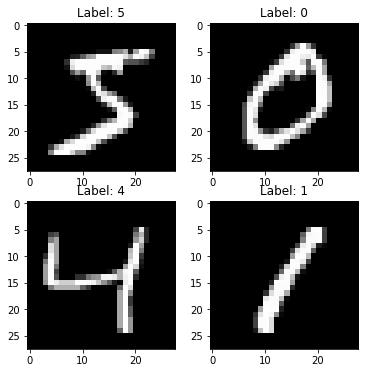

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

In [12]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X

    for layer in network:
        activation = layer.forward(input)
        activations.append(activation)
        input = activation
    assert len(activations) == len(network)
    return activations

def predict(network,X):
    """
    Compute network predictions.
    """
    logits = forward(network,X)[-1]
    return logits.argmax(axis=-1)

def train(network,X,y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    Then you can run layer.backward going from last to first layer.
    
    After you called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network,X)
    layer_inputs = [X]+layer_activations[:-1]  
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits,y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits,y)
    
    output_grad = loss_grad    
    for k in range(len(layer_inputs)):
        layer = network[-(k+1)]                #going back from last to first layer
        output_grad = layer.backward(layer_inputs[-(k+1)], output_grad)
    return np.mean(loss)

In [13]:
from tqdm import trange
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [14]:
def init_network(neurons, xavier=True, activation=lambda x, grad: relu(x, grad), output_activation=False, eta=0.1):
    """
    this function constructs list of layers of following order: dense-nonlin-dense-nonlin...-dense-(nonlin)
    neurons - list of neuron numbers in hidden layers
    activation - one of the nonlinear functions defined above
    you can also add output nonlinearity before softmax
    eta - learning rate for all layers
    """
    network= []
    neurons.insert(0,X_train.shape[1])
    if xavier:
        #scale = [2 / (a + b) for a,b in zip(neurons[:-2], neurons[2:])]
        #scale.append(1 / neurons[-2])
        # Xavier initialization. We scale all initital weights by (2/n_in)**0.5
        # where n_in - number of incoming signals to neuron
        # in order to make variance of weights be equal to 2/n_in
        scale = [(2 / a)**0.5 for a in neurons[:-1]]
    else: 
        scale = [1] * (len(neurons)-1)    #standard initialization with variance 1
    for k in range(len(neurons)-1):
        network.append(Dense(neurons[k], neurons[k+1], learning_rate=eta, init_scale=scale[k]))
        network.append(nonlin(act=activation))
    if not output_activation:
        del network[-1]
    return network

Now you can construct network in a convinient way and make some experiments.
As you can see I chose from the tasks the simpliest one)
Next i suggest two runs with network identical in all aspects except for weight initialization.
But of course you are free to make your own runs and reporting me about things i didn't notice)

In [15]:
from IPython.display import clear_output

In [16]:
def run(epochs):
    train_log = []
    val_log = []
    for epoch in range(epochs):

        for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=32,shuffle=True):
            train(network,x_batch,y_batch)

        train_log.append(np.mean(predict(network,X_train)==y_train))
        val_log.append(np.mean(predict(network,X_val)==y_val))

        clear_output()
        print("Epoch",epoch)
        print("Train accuracy:",train_log[-1])
        print("Val accuracy:",val_log[-1])
        plt.plot(train_log,label='train accuracy')
        plt.plot(val_log,label='val accuracy')
        plt.legend(loc='best')
        plt.grid()
        plt.show()
 

### Sigmoid

In [78]:
neurons = [100,100,100,100,100,100,100,100,100,100,10]
network = init_network(neurons, xavier=True, activation=lambda x, grad: sigmoid(x, grad), output_activation=False, eta=0.1)

Epoch 19
Train accuracy: 0.7533
Val accuracy: 0.7538


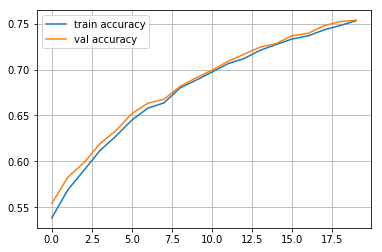

In [82]:
run(20)

In [83]:
neurons = [100,100,100,100,100,100,100,100,100,100,10]
network = init_network(neurons, xavier=False, activation=lambda x, grad: sigmoid(x, grad), output_activation=False, eta=0.1)

Epoch 19
Train accuracy: 0.73676
Val accuracy: 0.7449


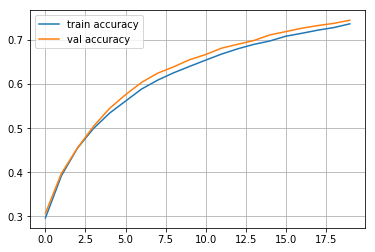

In [84]:
run(20)

Unexpected behaviour. To be honest I don't fully understand why small weights and sigmoid activation prevent learning. Maybe reducing weights by Xavier initialization makes output of first dense layer near 0 and first nonlin layer consequently near 0.5. And then deviation from 0.5 reduces with signal going deeper. So for the last layer we get 0.5 for all inputs. Nah, this explanation is bad..

### Tanh

In [85]:
neurons = [100,100,100,100,100,100,100,100,100,100,10]
network = init_network(neurons, xavier=True, activation=lambda x, grad: tanh(x, grad), output_activation=False, eta=0.1)

Epoch 4
Train accuracy: 0.96122
Val accuracy: 0.9561


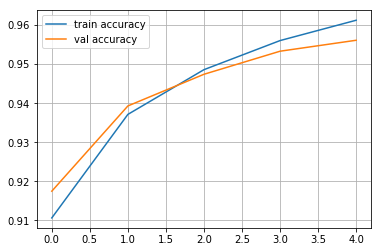

In [86]:
run(5)

In [87]:
neurons = [100,100,100,100,100,100,100,100,100,100,10]
network = init_network(neurons, xavier=False, activation=lambda x, grad: tanh(x, grad), output_activation=False, eta=0.1)

Epoch 4
Train accuracy: 0.10418
Val accuracy: 0.1097


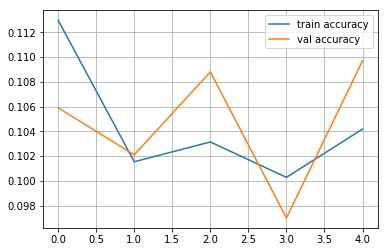

In [88]:
run(5)

In case of tanh activation, we also normalize every layer output. But due to big weights tanh outputs almost +1 and -1 that cancel each other in propagation through many layers. Comparing to sigmoid tanh changes faster near 0 and also can output negative values. 

### Softplus

In [52]:
neurons = [100,100,100,100,100,100,100,100,100,100,10]
network = init_network(neurons, xavier=True, activation=lambda x, grad: softplus(x, grad), output_activation=False, eta=0.1)

Epoch 4
Train accuracy: 0.96984
Val accuracy: 0.9658


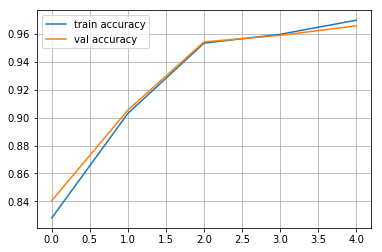

In [53]:
run(5)

In [54]:
neurons = [100,100,100,100,100,100,100,100,100,100,10]
network = init_network(neurons, xavier=False, activation=lambda x, grad: softplus(x, grad), output_activation=False, eta=0.1)

Epoch 4
Train accuracy: 0.09864
Val accuracy: 0.0991


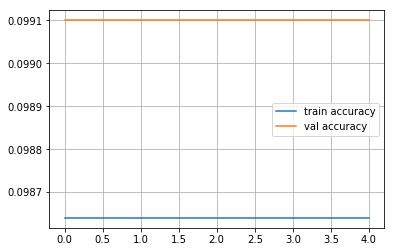

In [55]:
run(5)

It is not a surpise that softplus activation results in enourmos signal in case of not scaled weights. This is the reason learning becomes unavailible. We are waiting the same result for relu)

### Relu

In [76]:
neurons = [100,200,10]
network = init_network(neurons, xavier=True, activation=lambda x, grad: relu(x, grad), output_activation=False, eta=0.1)

Epoch 24
Train accuracy: 0.964
Val accuracy: 0.9607


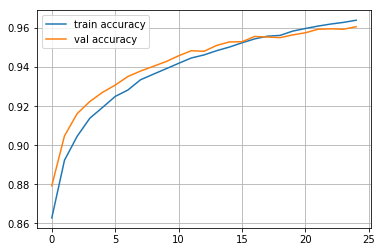

In [77]:
run(25)

In [73]:
neurons = [100,200,10]
network = init_network(neurons, xavier=False, activation=lambda x, grad: relu(x, grad), output_activation=False, eta=0.1)

Epoch 24
Train accuracy: 0.09864
Val accuracy: 0.0991


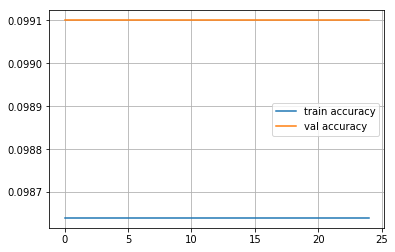

In [74]:
run(25)

Yes, the same behaviour as with softplus activation

# Conclusion
Xavier initialization equalizes input and output variance of layers, so it prevents from enourmos growth of signal through propagation in case of softplus and relu activations. In case of tanh equalizing variances prevent from all output of nonlin layer to be +1 or -1 independently of input of dense layer. Unexpected behaviour is observed in case of sigmoid activation. I hope you will find out what is the reason and report it)
Thank you for reading. I hope all was clear and code is nice enough to male some experiments by youself.
Good luck next tasks! Maybe we will meet again)